## Pseudo-spectral projection

Pseudo-spectral projection method is one of two non-intrusive polynomial
chaos expansion methods. (The other being point collocation method.) In a
nutshell it can be performed as follows:

1. Generate nodes $Q_1, ..., Q_N$ and weights $W_1, ..., W_N$ from a
   [quadrature integration](../fundamentals/quadrature_integration.ipynb) scheme.
2. Use nodes to create model evaluations $U_1, ..., U_N$.
3. Select an expansion of orthogonal polynomials $P_1, ..., P_M$.
4. Estimate Fourier coefficients $c_1, ..., c_M$, creating model
   approximation $\hat u(q) = \sum_i c_i P_i$.
5. Perform model analysis on approximation $\hat u(q)$ as a proxy for the
   real model.

Let us go through the steps in more detail.

### Generate quadrature nodes and weights

In pseudo spectral projection, the nodes used to evaluate the model have to
be taken from [quadrature integration scheme](../fundamentals/quadrature_integration.ipynb).

For example, we can choose full tensor-grid with optimal Gaussian quadrature,
and Smolyak sparse-grid with Genz-Keister and Clenshaw-Curtis quadrature:

In [1]:
import chaospy
from problem_formulation import joint

gauss_quads = [
    chaospy.generate_quadrature(order, joint, rule="gaussian")
    for order in range(1, 8)
]

In [2]:
sparse_quads = [
    chaospy.generate_quadrature(
        order, joint, rule=["genz_keister_24", "clenshaw_curtis"], sparse=True)
    for order in range(1, 5)
]

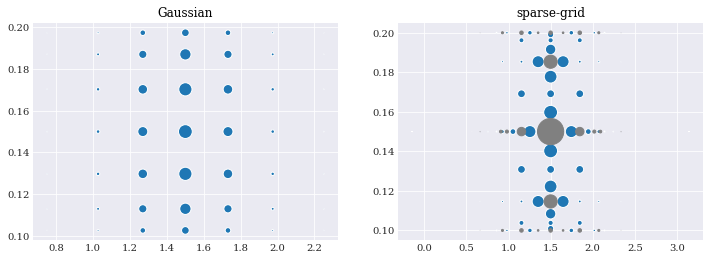

In [3]:
from matplotlib import pyplot

pyplot.rc("figure", figsize=[12, 4])

nodes, weights = gauss_quads[5]

pyplot.subplot(121)
pyplot.title("Gaussian")
pyplot.scatter(*nodes, s=weights*2e3)

nodes, weights = sparse_quads[3]
idx = weights > 0

pyplot.subplot(122)
pyplot.title("sparse-grid")
pyplot.scatter(*nodes[:, idx], s=weights[idx]*2e3)
pyplot.scatter(*nodes[:, ~idx], s=-weights[~idx]*2e3, color="grey")

pyplot.show()

### Evaluating model solver

Like in the case of [problem formulation](./problem_formulation.ipynb) again,
evaluation is straight forward:

In [4]:
from problem_formulation import model_solver, coordinates
import numpy

gauss_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes, weights in gauss_quads
]

In [5]:
sparse_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes, weights in sparse_quads
]

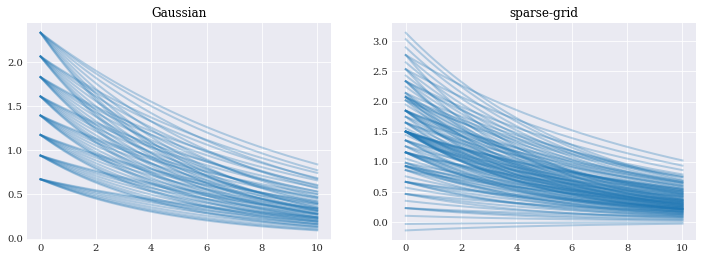

In [6]:
pyplot.subplot(121)
pyplot.plot(coordinates, gauss_evals[6].T, alpha=0.3)
pyplot.title("Gaussian")

pyplot.subplot(122)
pyplot.plot(coordinates, sparse_evals[3].T, alpha=0.3)
pyplot.title("sparse-grid")

pyplot.show()

### Expansion of orthogonal polynomials

Unlike [point collocation](./point_collocation.ipynb) method, the polynomials
in pseudo-spectral projection needs to be orthogonal for the method to work.
This can be achieved by using the
[chaospy.generate_expansion()](../../reference/api/chaospy.generate_expansion.rst)
function:

In [7]:
expansions = [chaospy.generate_expansion(order, joint)
              for order in range(1, 10)]
expansions[0].round(10)

polynomial([1.0, q1-0.15, q0-1.5])

### Fourier coefficients

Polynomial chaos expansion assumes that we can model function $u$ using an
expansion:

$$
u(q) \approx \hat u(q) = \sum_{i=1}^N c_i P_i
$$

Since $P_1, \dots, P_N$ are orthogonal, the optimal selection for $c_1,
\dots, c_N$, the Fourier coefficients becomes:

$$
  c_i = \frac{\left\langle u, P_i\right\rangle}{
              \left\langle P_i, P_i\right\rangle}
$$

These coefficients can be estimated in pseudo-spectral projection using
quadrature integration. In `chaospy` we calculate the model approximation
directly through the
[chaospy.fit_quadrature()](../../reference/api/chaospy.fit_quadrature.rst)
function:

In [8]:
gauss_model_approx = [
    chaospy.fit_quadrature(expansion, nodes, weights, evals)
    for expansion, (nodes, weights), evals in zip(expansions, gauss_quads, gauss_evals)
]

In [9]:
sparse_model_approx = [
    chaospy.fit_quadrature(expansion, nodes, weights, evals)
    for expansion, (nodes, weights), evals in zip(expansions, sparse_quads, sparse_evals)
]

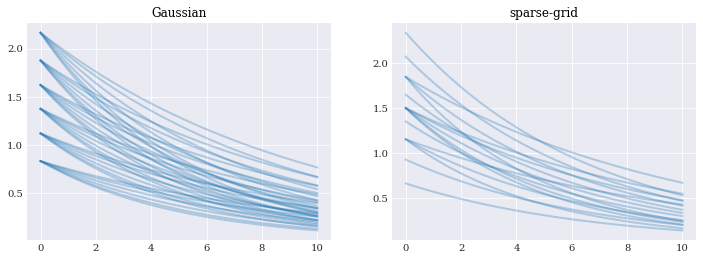

In [10]:
model_approx = gauss_model_approx[4]
nodes, _ = gauss_quads[4]
evals = model_approx(*nodes)

pyplot.subplot(121)
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Gaussian")

model_approx = sparse_model_approx[1]
nodes, _ = sparse_quads[1]
evals = model_approx(*nodes)

pyplot.subplot(122)
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("sparse-grid")

pyplot.show()

Note that if the Fourier coefficients are needed, then they are still
accessible by passing `retall=True` to
[chaospy.fit_quadrature()](../../reference/api/chaospy.fit_quadrature.rst).

### Descriptive statistics

The expected value and variance is calculated as follows:

In [11]:
expected = chaospy.E(gauss_model_approx[-2], joint)
std = chaospy.Std(gauss_model_approx[-2], joint)

expected[:4].round(4), std[:4].round(4)

(array([1.5   , 1.4977, 1.4955, 1.4933]),
 array([0.2   , 0.1997, 0.1994, 0.1991]))

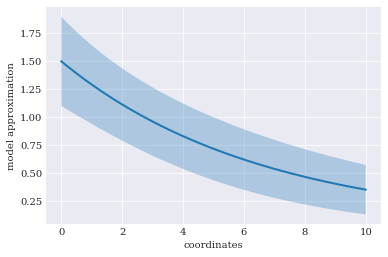

In [12]:
pyplot.rc("figure", figsize=[6, 4])

pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
pyplot.fill_between(
    coordinates, expected-2*std, expected+2*std, alpha=0.3)
pyplot.plot(coordinates, expected)

pyplot.show()

### Error analysis

It is hard to assess how well these models are doing from the final
estimation alone. They look about the same. So to compare results, we do
error analysis. To do so, we use the reference analytical solution and error
function as defined in  [problem formulation](./problem_formulation.ipynb).

In [13]:
from problem_formulation import error_in_mean, error_in_variance

error_in_mean(expected), error_in_variance(std**2)

(6.994405055138486e-16, 2.0112904397517896e-15)

The analysis can be performed as follows:

In [14]:
gauss_sizes = [len(weights) for _, weights in gauss_quads]
eps_gauss_mean = [
    error_in_mean(chaospy.E(model, joint))
    for model in gauss_model_approx
]
eps_gauss_var = [
    error_in_variance(chaospy.Var(model, joint))
    for model in gauss_model_approx
]

In [15]:
sparse_sizes = [len(weights) for _, weights in sparse_quads]
eps_sparse_mean = [
    error_in_mean(chaospy.E(model, joint))
    for model in sparse_model_approx
]
eps_sparse_var = [
    error_in_variance(chaospy.Var(model, joint))
    for model in sparse_model_approx
]

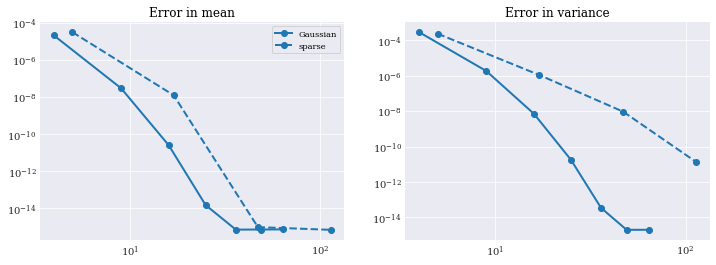

In [16]:
pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(121)
pyplot.title("Error in mean")
pyplot.loglog(gauss_sizes, eps_gauss_mean, "o-", label="Gaussian")
pyplot.loglog(sparse_sizes, eps_sparse_mean, "o--", label="sparse")
pyplot.legend()

pyplot.subplot(122)
pyplot.title("Error in variance")
pyplot.loglog(gauss_sizes, eps_gauss_var, "o-", label="Gaussian")
pyplot.loglog(sparse_sizes, eps_sparse_var, "o--", label="sparse")

pyplot.show()

Note that the convergence at around $10^{-16}$ is where machine precision
starts to matter more than the accuracy of the approximation by itself.